# 2차세계대전 날씨 데이터를 이용한 ARIMA

In [12]:
!pip install chart-studio
! pip install plotly==5.4.0

  Created wheel for retrying: filename=retrying-1.3.3-py3-none-any.whl size=11447 sha256=347cef56a4f8651ec14566c6b475605a8e959b7cfef57a22ac38ce64e8885921
  Stored in directory: c:\users\user\appdata\local\pip\cache\wheels\ce\18\7f\e9527e3e66db1456194ac7f61eb3211068c409edceecff2d31
Successfully built retrying
Note: you may need to restart the kernel to use updated packages.


In [38]:
!pip install --upgrade statsmodels

In [40]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns # visualization library
import matplotlib.pyplot as plt # visualization library
from chart_studio import plotly as py #visualization library
from plotly.offline import init_notebook_mode, iplot # plotly offline mode
init_notebook_mode(connected=True) 
import plotly.graph_objs as go # plotly graphical object

In [41]:
import os
# import warnings library
import warnings        
# ignore filters
warnings.filterwarnings("ignore") # if there is a warning after some codes, this will avoid us to see them.
plt.style.use('ggplot') # style of plots. ggplot is one of the most used style, I also like it.
# Any results you write to the current directory are saved as output.

In [42]:
# 분석에 필요한 칼럼만 불러오기

weather_station_location = pd.read_csv('./Weather Station Locations.csv')
weather = pd.read_csv('./Summary of Weather.csv')
weather_station_location = weather_station_location.loc[:,["WBAN", "NAME", 
                            "STATE/COUNTRY ID", "Latitude", "Longitude"]]
weather = weather.loc[:,["STA", "Date", "MeanTemp"]]

In [43]:
weather_station_location.head()

,WBAN,NAME,STATE/COUNTRY ID,Latitude,Longitude
0,33013,AIN EL,AL,36.383333,6.650000
1,33031,LA SENIA,AL,35.616667,0.583333
2,33023,MAISON BLANCHE,AL,36.716667,3.216667
3,33044,TELERGMA,AL,36.116667,6.416667
4,12001,TINDOUF,AL,27.683333,-8.083333


In [113]:
weather_station_location.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161 entries, 0 to 160
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   WBAN              161 non-null    int64  
 1   NAME              161 non-null    object 
 2   STATE/COUNTRY ID  161 non-null    object 
 3   Latitude          161 non-null    float64
 4   Longitude         161 non-null    float64
dtypes: float64(2), int64(1), object(2)
memory usage: 6.4+ KB


In [44]:
weather.head()

,STA,Date,MeanTemp
0,10001,1942-7-1,23.888889
1,10001,1942-7-2,25.555556
2,10001,1942-7-3,24.444444
3,10001,1942-7-4,24.444444
4,10001,1942-7-5,24.444444


In [112]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119040 entries, 0 to 119039
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   STA       119040 non-null  int64  
 1   Date      119040 non-null  object 
 2   MeanTemp  119040 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 2.7+ MB


In [45]:
# 여러 지역 중 BINDUKURI 지역에 대한 일 평균 온도를 대상으로 분석 진행
weather_station_id = weather_station_location[weather_station_location.NAME == 'BINDUKURI'].WBAN
weather_bin = weather[weather.STA == int(weather_station_id)]
weather_bin["Date"] = pd.to_datetime(weather_bin['Date'])
weather_bin

# 1943년 5월 11일부터 1945년 5월 31일까지 일단위 평균 온도이다.

,STA,Date,MeanTemp
78252,32907,1943-05-11,28.888889
78253,32907,1943-05-12,25.555556
78254,32907,1943-05-13,24.444444
78255,32907,1943-05-14,23.888889
78256,32907,1943-05-15,27.777778
...,...,...,...
78998,32907,1945-05-27,23.333333
78999,32907,1945-05-28,25.555556
79000,32907,1945-05-29,24.444444
79001,32907,1945-05-30,25.555556


In [114]:
weather_bin.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 751 entries, 78252 to 79002
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   STA       751 non-null    int64         
 1   Date      751 non-null    datetime64[ns]
 2   MeanTemp  751 non-null    float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 23.5 KB


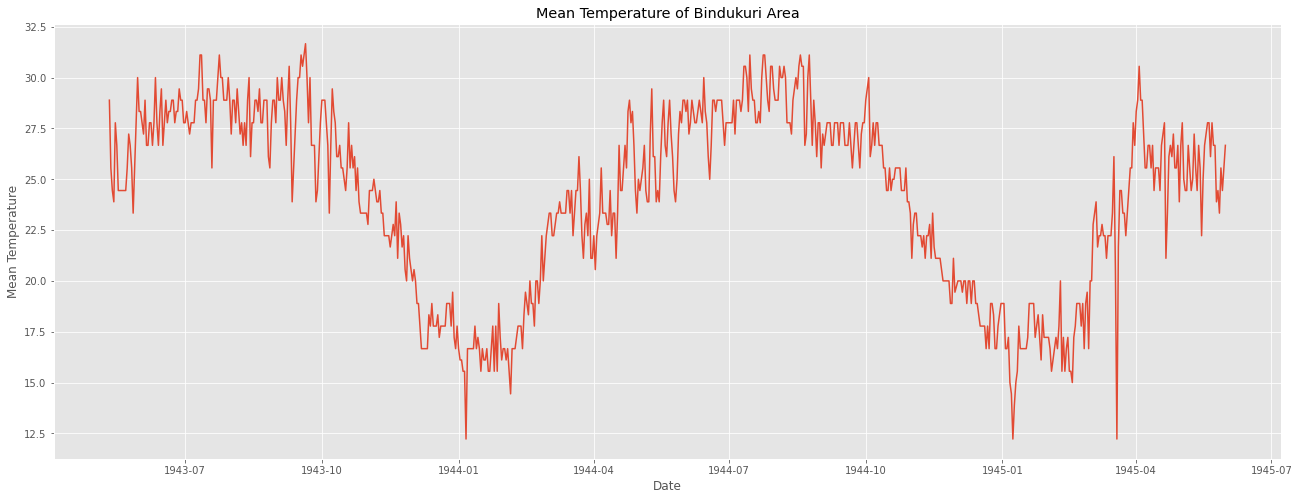

In [46]:
# 이를 통해 시계열 그래프 그려보기

plt.figure(figsize = (22,8))
plt.plot(weather_bin.Date, weather_bin.MeanTemp)
plt.title("Mean Temperature of Bindukuri Area")
plt.xlabel("Date")
plt.ylabel("Mean Temperature")
plt.show()

In [47]:
# 이를 시계열 분해법으로 분해해보면 다음과 같다.
# 먼저 시계열 형태의 ts데이터 만들어주기
# lets create time series from weather
timeSeries = weather_bin.loc[:, ["Date", "MeanTemp"]]
timeSeries.index = timeSeries.Date
ts = timeSeries.drop("Date", axis =1)
ts

,MeanTemp
Date,
1943-05-11,28.888889
1943-05-12,25.555556
1943-05-13,24.444444
1943-05-14,23.888889
1943-05-15,27.777778
...,...
1945-05-27,23.333333
1945-05-28,25.555556
1945-05-29,24.444444


<Figure size 432x288 with 0 Axes>

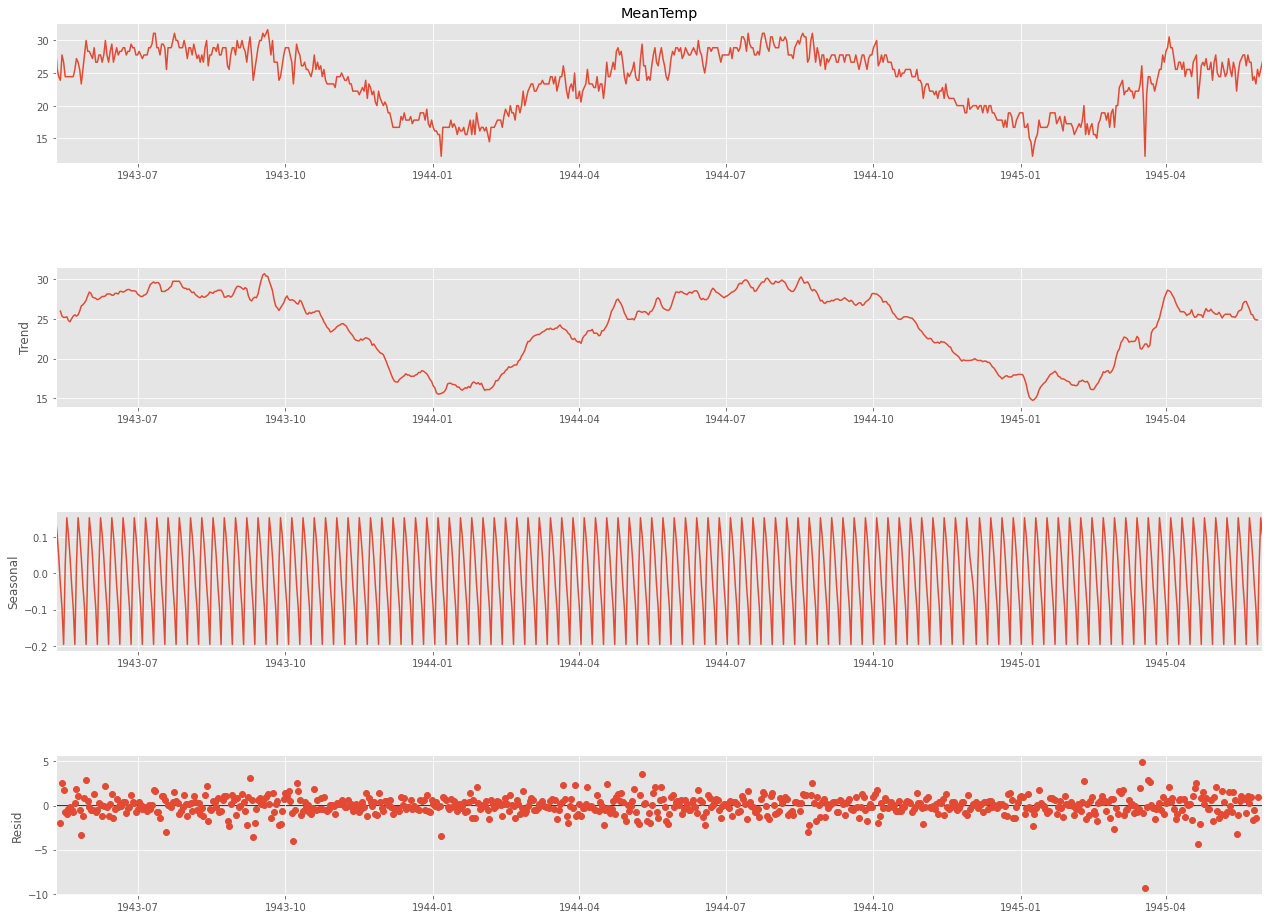

In [52]:
# 다음으로 seasonal_decompose() 를 이용해서 분해한다.

from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(ts["MeanTemp"], model = 'additive', period = 7)

fig = plt.figure()
fig = result.plot()
fig.set_size_inches(20,15)

데이터가 패턴이 보이므로 정상성이 의심되는 상황이다. 이를 판단하기 위해 ACF 그래프를 그려보자

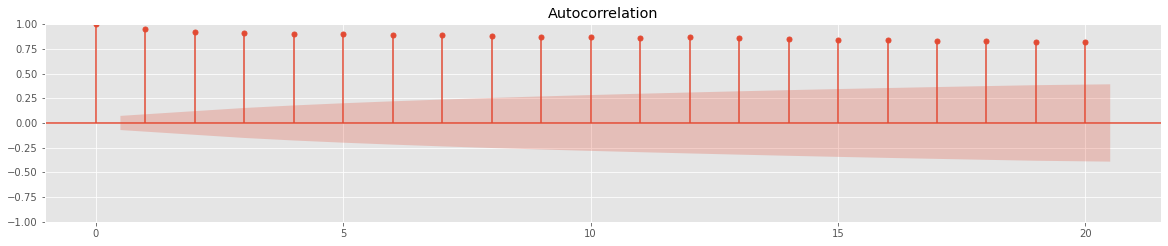

In [53]:
import statsmodels.api as sm

fig = plt.figure(figsize = (20,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(ts, lags=20, ax=ax1)

# 값이 아주아주 천천히 작아진다.

값이 아주아주 천천히 작아진다는 것은 정상성을 만족하지 않는것을 의미한다.

단위근 검정인 ADF 검정으로 정상성 확인
귀무가설 : 자료에 단위근이 존재한다. 정상성을 만족하지 않는다.
대립가설 : 자료가 정상성을 만족한다.

In [57]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(ts)
print("ADF Statistic : %f" % result[0])
print('p-value : %f' % result[1])
print('Critical Values : ')
for key, value in result[4].items() :
    print('\t%s : %.3f' % (key,value))

ADF Statistic : -1.409597
p-value : 0.577667
Critical Values : 
	1% : -3.439
	5% : -2.865
	10% : -2.569


p-value 가 0.05를 넘으므로, 귀무가설을  채택한다. 해당데이터는 정상성을 만족하지 않는다.

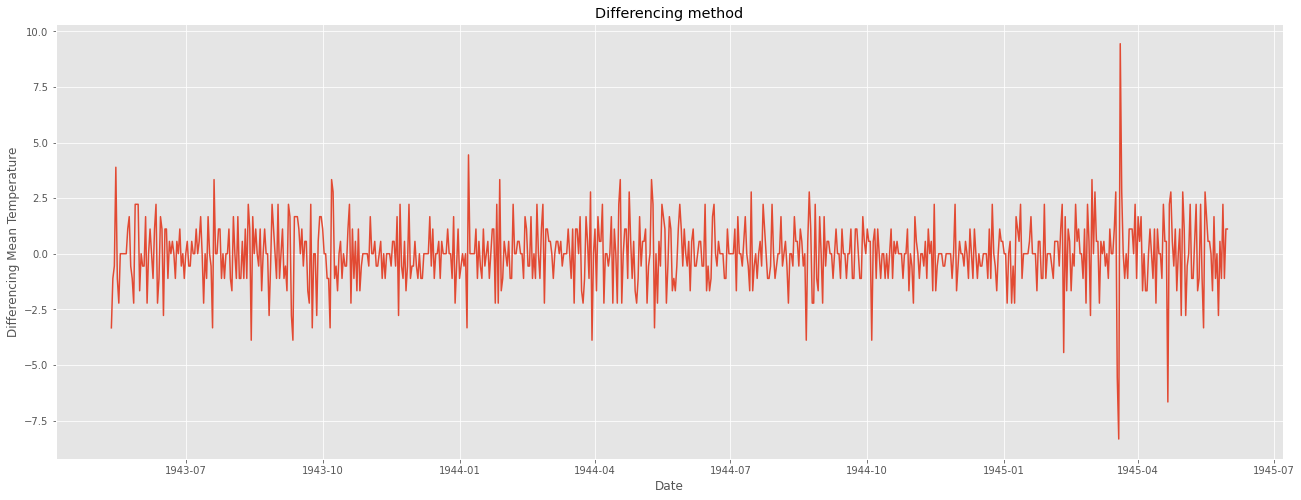

In [59]:
# 이를 해결하기 위한 1차차분 진행
ts_diff = ts - ts.shift()
plt.figure(figsize = (22,8))
plt.plot(ts_diff)
plt.title("Differencing method")
plt.xlabel("Date")
plt.ylabel("Differencing Mean Temperature")
plt.show()

일정한 패턴이 확인되지 않고, 정상성을 만족하는 듯 보인다.
ADF 검정 결과는 다음과 같다.

In [60]:
result = adfuller(ts_diff[1:])
print("ADF Statistic : %f" % result[0])
print("p-value : %f" % result[1])
print("Critical Values : ")
for key, value in result[4].items():
    print('\t%s : %.3f' % (key,value))

ADF Statistic : -11.678956
p-value : 0.000000
Critical Values : 
	1% : -3.439
	5% : -2.865
	10% : -2.569


p-value 가 0.05  보다 작으므로 귀무가설을 기각한다. 즉 1차 차분한 데이터는 정상성을 만족한다.
이 차분한 데이터로 ACF와 PACF 그래프를 그려서 ARIMA 모형의 p 와 q 를 결정한다.

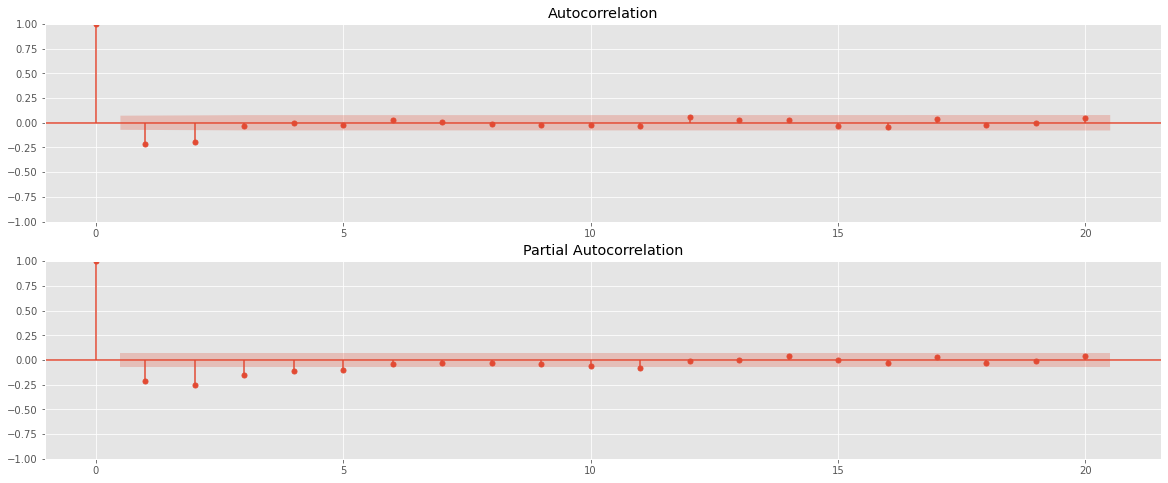

In [61]:
import statsmodels.api as sm

fig = plt.figure(figsize = (20,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(ts_diff[1:], lags=20, ax=ax1)
#
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(ts_diff[1:], lags=20, ax=ax2)

ACF 와 PACF 모두 0에 수렴하고, 2번째 lag 이후에 0에 수렴한다.
즉 , ARIMA(2,1,2) 모형을 base model로, ARIMA(2,1,1), ARIMA(1,1,2), ARIMA(1,1,1) 등의
모델을 시도해볼 수 있다.

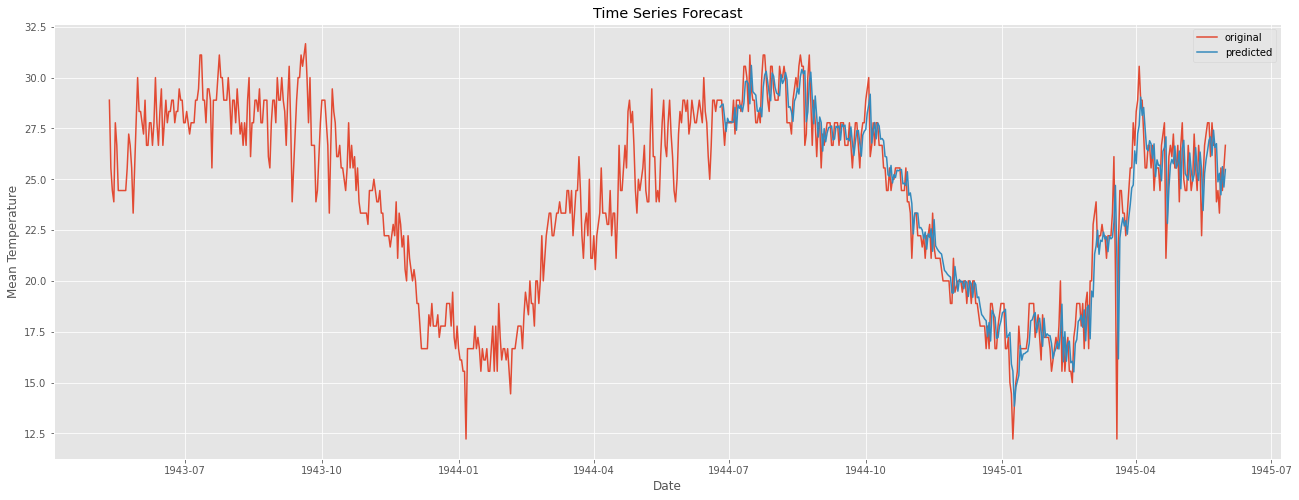

In [89]:
# ARIMA(2,1,2) 모델 결과
import statsmodels.api as sm
from pandas import datetime
from statsmodels.tsa.arima.model import ARIMA

# fit model
model = ARIMA(ts, order=(2,1,2))
model_fit = model.fit()

# predict
start_index = datetime(1944, 6, 25)
end_index = datetime(1945, 5, 31)
forecast = model_fit.predict(start = start_index, end = end_index, typ ='levels')

# visualization
plt.figure(figsize = (22,8))
plt.plot(weather_bin.Date, weather_bin.MeanTemp, label = "original")
plt.plot(forecast, label = "predicted")
plt.title("Time Series Forecast")
plt.xlabel("Date")
plt.ylabel("Mean Temperature")
plt.legend()
plt.show()

눈으로 볼 때는 결과가 아주 좋아보인다. 마지막으로 잔차 분석을 통해 모델에 빠진 것은 없는 지,
문제가 없는 지 확인한다. 
여기서 잔차는 어떠한 패턴이나 특성이 나타나서는 안 된다.
어떤 패턴이 있다는 것은 모델에 그만큼 덜 작용이 되었다는 것을 의미하기 때문이다.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


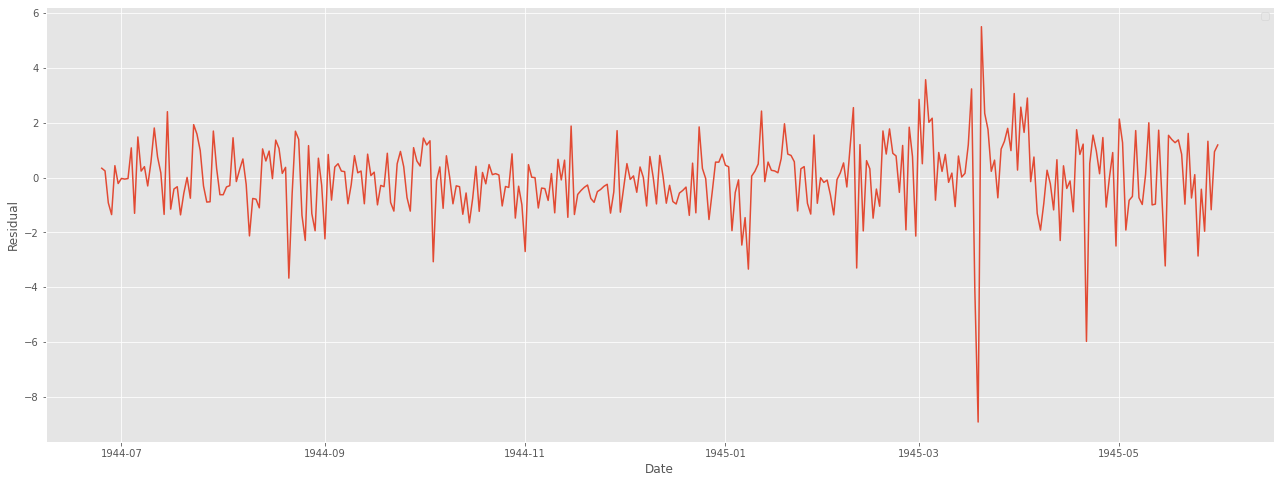

In [90]:
resi = np.array(weather_bin[weather_bin.Date>=start_index].MeanTemp) - np.array(forecast)

plt.figure(figsize = (22,8))
plt.plot(weather_bin.Date[weather_bin.Date>=start_index],resi)

plt.xlabel("Date")
plt.ylabel("Residual")
plt.legend()
plt.show()

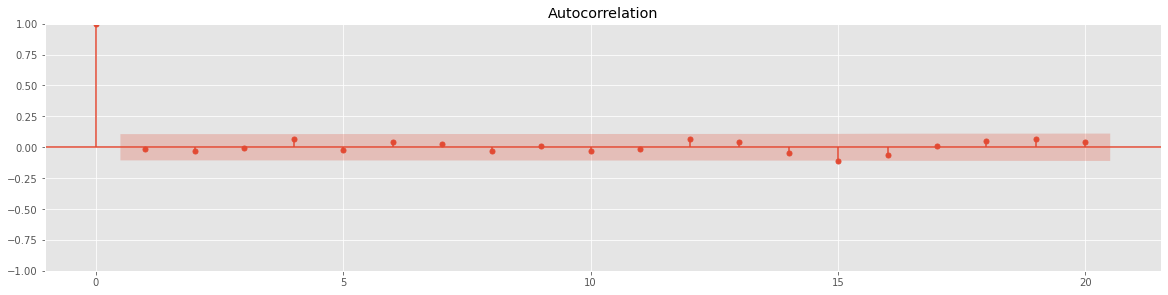

In [92]:
# ACF 그래프 및 ADF 검정을 통해서 정상성도 판단한다.
fig = plt.figure(figsize = (20,10))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(resi, lags=20, ax=ax1)

In [93]:
result = adfuller(resi)
print("ADF Statistic : %f" % result [0])
print("p-value : %f" % result[1])
print("Critical Values : ")
for key, value in result[4].items() :
    print("\t%s : %.3f" % (key, value))

ADF Statistic : -18.629906
p-value : 0.000000
Critical Values : 
	1% : -3.450
	5% : -2.870
	10% : -2.571


ACF 그래프도 빠르게 0 으로 수렴하고, ADF 검정 역시 p-value 가 매우 작은 것을 볼 수 있다.
마지막으로 성능 확인

In [110]:
from sklearn import metrics

def scoring(y_true , y_pred) : 
    r2 = round(metrics.r2_score(y_true, y_pred) * 100, 3)
    corr = round(np.corrcoef(y_true, y_pred)[0,1], 3)
    mape = round(metrics.mean_absolute_percentage_error(y_true, y_pred) * 100, 3)
    rmse = round(metrics.mean_squared_error(y_true, y_pred, squared= False), 3)
                                                    
    
    df = pd.DataFrame({
            "R2" : r2,
            "Corr" : corr,
            "RMSE" : rmse,
            "MAPE" : mape
    }, index = [0])

    return df

In [111]:
scoring(np.array(weather_bin[weather_bin.Date>=start_index].MeanTemp), np.array(forecast))

,R2,Corr,RMSE,MAPE
0,91.018,0.954,1.365,4.449


error:  2.841395328567663


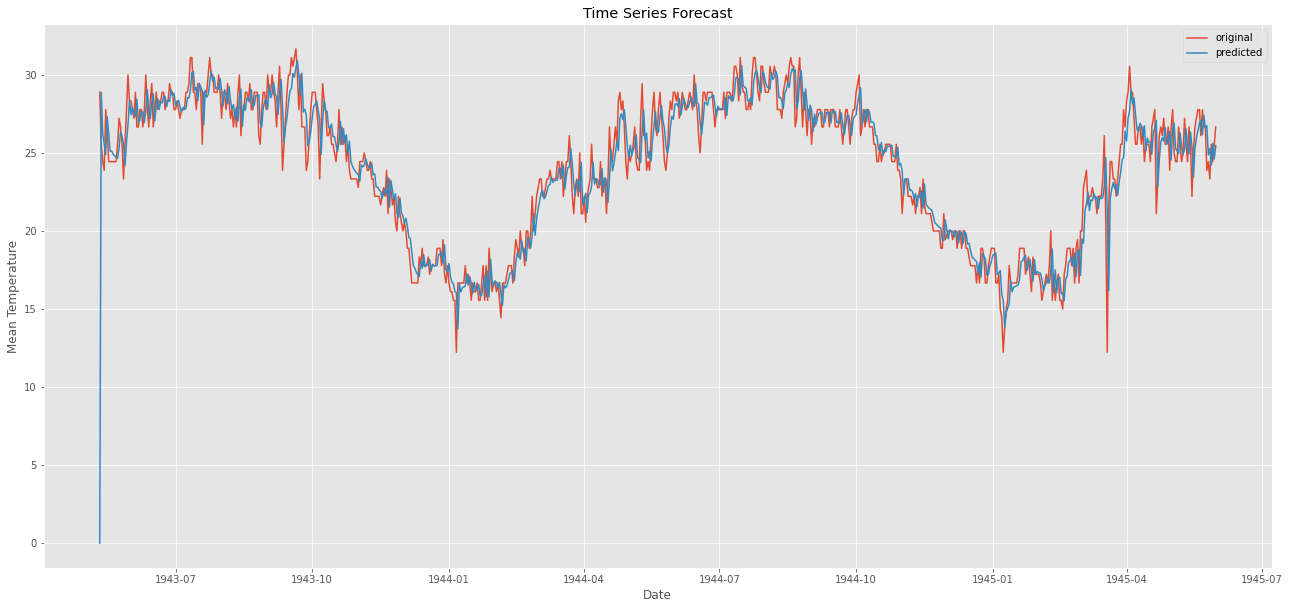

In [117]:
from sklearn.metrics import mean_squared_error

# fit model
forecast2 = model_fit.predict()
error = mean_squared_error(ts, forecast2)
print("error: " ,error)

# visualization
plt.figure(figsize=(22,10))
plt.plot(weather_bin.Date,weather_bin.MeanTemp,label = "original")
plt.plot(forecast2,label = "predicted")
plt.title("Time Series Forecast")
plt.xlabel("Date")
plt.ylabel("Mean Temperature")
plt.legend()
plt.savefig('graph.png')

plt.show()